In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
# %pip install scikit-learn --quiet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
sns.set(style="whitegrid")


In [2]:
# read data
df = pd.read_excel("Dataset.xlsx", sheet_name=0)
df.head()

,student_id,name,class,study,gpa,greek,off_campus,distance_to_campus,gender,sprinklered,coverage,claim_id,amount,risk_tier,holdout
0,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Additional Living Expense,0,0.0,2,False
1,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Guest Medical,0,0.0,2,False
2,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Liability,0,0.0,2,False
3,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Personal Property,0,0.0,2,False
4,2,"Reddy, Dawna",Junior,Science,0.609616,Non-greek,On campus,0.0,Female,True,Additional Living Expense,0,0.0,2,False


In [3]:
# use only loss data
df_loss = df[df['amount'] > 0].copy()
print(len(df_loss))

# set large loss threshold
threshold = df_loss['amount'].quantile(0.95)
print(threshold)



1819
18068.382995999993


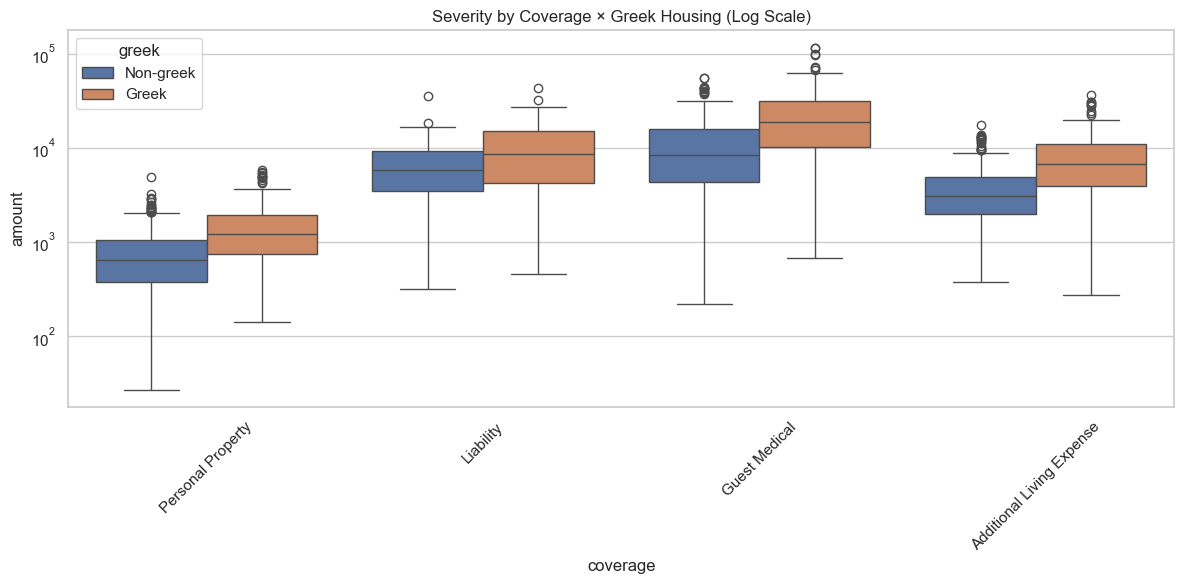

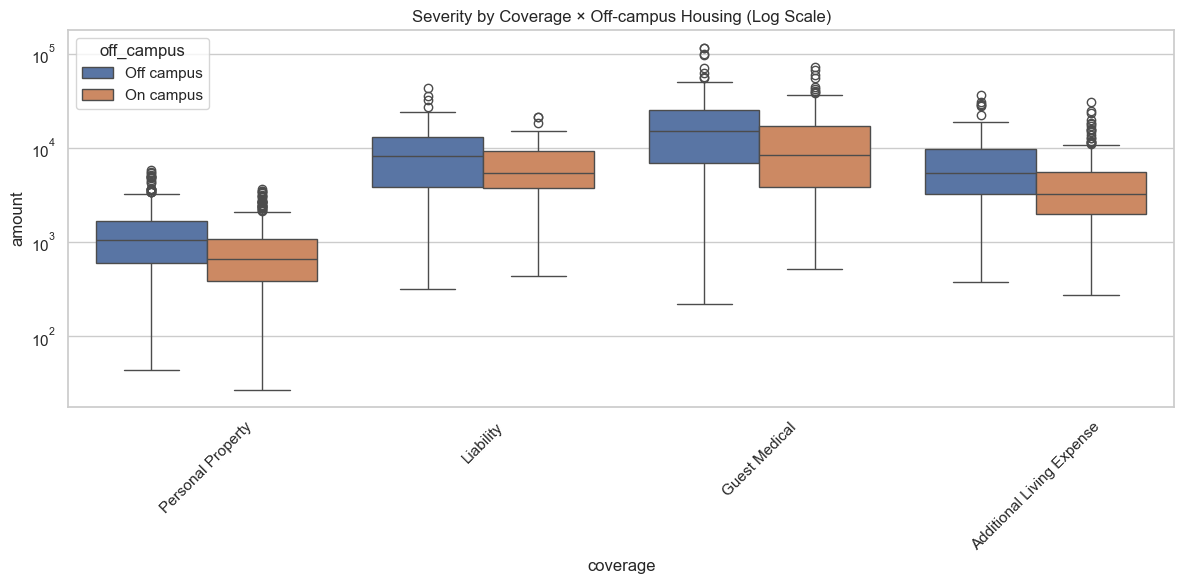

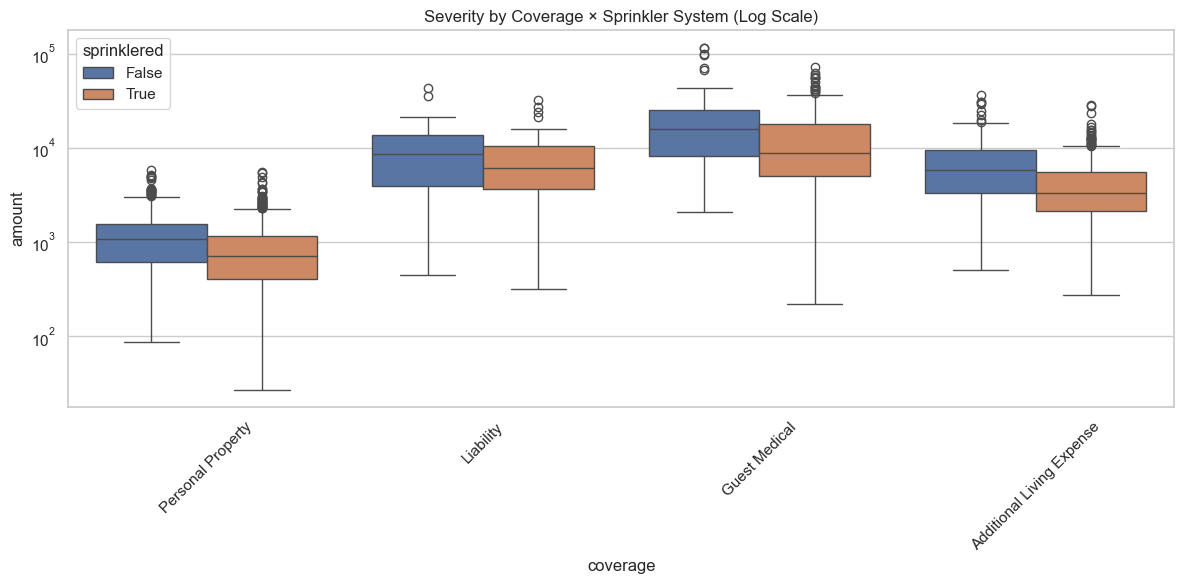

In [4]:
def plot_box_by_group(variable, label):
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_loss,
        x="coverage",
        y="amount",
        hue=variable,
        showfliers=True
    )
    plt.yscale("log")
    plt.title(f"Severity by Coverage × {label} (Log Scale)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_box_by_group("greek", "Greek Housing")
plot_box_by_group("off_campus", "Off-campus Housing")
plot_box_by_group("sprinklered", "Sprinkler System")


In [5]:
def large_loss_table(variable):
    return (
        df_loss.assign(large = df_loss["amount"] > threshold)
               .groupby(["coverage", variable])
               .agg(
                     count=("amount", "count"),
                     large_losses=("large", "sum"),
                     large_rate=("large", "mean")
               )
               .reset_index()
               .assign(large_rate = lambda x: (x["large_rate"]*100).round(2))
    )

table_greek = large_loss_table("greek")
print(table_greek)

print("\n")
table_off = large_loss_table("off_campus")
print(table_off)

print("\n")
table_sprinkler = large_loss_table("sprinklered")
print(table_sprinkler)


                    coverage      greek  count  large_losses  large_rate
0  Additional Living Expense      Greek    187            12        6.42
1  Additional Living Expense  Non-greek    341             0        0.00
2              Guest Medical      Greek     71            38       53.52
3              Guest Medical  Non-greek    162            32       19.75
4                  Liability      Greek     35             7       20.00
5                  Liability  Non-greek     50             2        4.00
6          Personal Property      Greek    332             0        0.00
7          Personal Property  Non-greek    641             0        0.00


                    coverage  off_campus  count  large_losses  large_rate
0  Additional Living Expense  Off campus    207             7        3.38
1  Additional Living Expense   On campus    321             5        1.56
2              Guest Medical  Off campus    107            43       40.19
3              Guest Medical   On campus    1

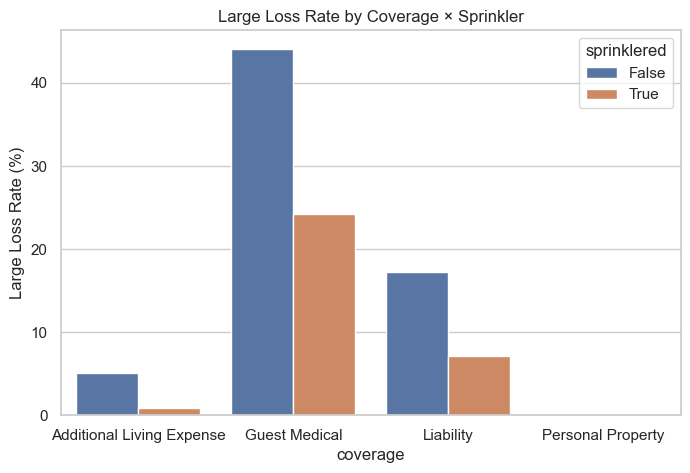

In [6]:

plt.figure(figsize=(8,5))
sns.barplot(
    data=table_sprinkler,
    x="coverage",
    y="large_rate",
    hue="sprinklered"
)
plt.title("Large Loss Rate by Coverage × Sprinkler")
plt.ylabel("Large Loss Rate (%)")
plt.show()


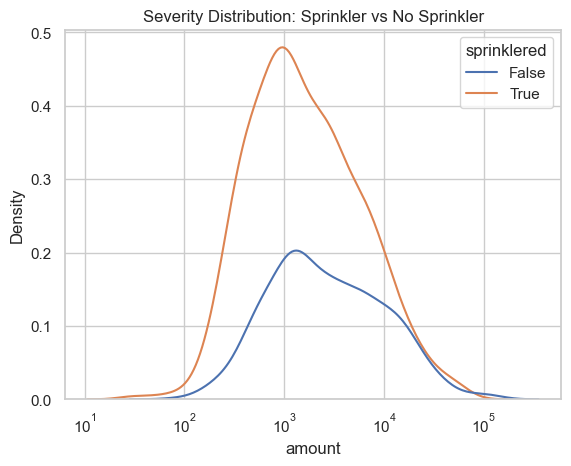

In [7]:
sns.kdeplot(
    data=df_loss, 
    x="amount", 
    hue="sprinklered", 
    log_scale=True
)
plt.title("Severity Distribution: Sprinkler vs No Sprinkler")
plt.show()


In [ ]:
# which combinations are most dangerous(risky)?(coverage + greek + off_campus + sprinklered)
danger_table = (
    df_loss.assign(large = df_loss["amount"] > threshold)
           .groupby(["coverage","greek","off_campus","sprinklered"])["large"]
           .mean() # average large loss rate
           .reset_index()
           .sort_values("large", ascending=False)
)

danger_table

,coverage,greek,off_campus,sprinklered,large
8,Guest Medical,Greek,Off campus,False,1.000000
9,Guest Medical,Greek,Off campus,True,0.611111
12,Guest Medical,Non-greek,Off campus,False,0.520000
10,Guest Medical,Greek,On campus,False,0.454545
11,Guest Medical,Greek,On campus,True,0.411765
16,Liability,Greek,Off campus,False,0.333333
17,Liability,Greek,Off campus,True,0.300000
18,Liability,Greek,On campus,False,0.222222
13,Guest Medical,Non-greek,Off campus,True,0.196429
0,Additional Living Expense,Greek,Off campus,False,0.178571


* Catastrophic Loss Analysis

In [9]:
# catastrophic rows
cat = df_loss[df_loss["amount"] > threshold]

print("Catastrophic loss count:", len(cat))
print("Total severity in catastrophic:", cat["amount"].sum())

# segmentation by coverage
cat_by_coverage = (
    cat.groupby("coverage")["amount"]
       .agg(["count", "mean", "median", "sum"])
       .sort_values("count", ascending=False)
)
print("\nCatastrophic Loss Breakdown by Coverage:")
cat_by_coverage



Catastrophic loss count: 91
Total severity in catastrophic: 3131747.80071

Catastrophic Loss Breakdown by Coverage:


,count,mean,median,sum
coverage,,,,
Guest Medical,70,36846.798253,28185.795295,2.579276e+06
Additional Living Expense,12,25912.754073,26169.862460,3.109530e+05
Liability,9,26835.430461,24145.376390,2.415189e+05


In [10]:
# segmentation by housing attributes
cat_by_attr = (
    cat.groupby(["greek", "off_campus", "sprinklered"])["amount"]
       .agg(["count", "mean", "median"])
       .sort_values("count", ascending=False)
)
print("\nCatastrophic Loss Breakdown by Housing Attributes:")
cat_by_attr


Catastrophic Loss Breakdown by Housing Attributes:


count          mean        median
greek     off_campus sprinklered                                   
Greek     Off campus True            16  32508.936110  28079.457970
          On campus  True            16  32602.405354  25749.279465
Non-greek Off campus False           15  27703.313062  25453.108130
Greek     Off campus False           14  55225.571279  37542.627550
          On campus  False           11  26345.743934  21448.042730
Non-greek Off campus True            11  31644.811858  26497.898970
          On campus  False            4  26711.602425  24506.727880
                     True             4  39129.030012  40279.913785

In [11]:
# Proportion of Greek among catastrophic losses
print("Greek proportion in catastrophic:", 
      cat["greek"].value_counts(normalize=True))

# Proportion of Off-campus among catastrophic losses
print("Off-campus proportion in catastrophic:",
      cat["off_campus"].value_counts(normalize=True))

# Proportion of Sprinklered among catastrophic losses
print("Sprinkler proportion in catastrophic:",
      cat["sprinklered"].value_counts(normalize=True))

# Joint segmentation
cat_joint = (
    cat.groupby(["coverage", "greek", "off_campus", "sprinklered"])
       ["amount"].agg(["count", "mean", "max"])
       .sort_values("count", ascending=False)
)
cat_joint


Greek proportion in catastrophic: greek
Greek        0.626374
Non-greek    0.373626
Name: proportion, dtype: float64
Off-campus proportion in catastrophic: off_campus
Off campus    0.615385
On campus     0.384615
Name: proportion, dtype: float64
Sprinkler proportion in catastrophic: sprinklered
True     0.516484
False    0.483516
Name: proportion, dtype: float64


count  \
coverage                  greek     off_campus sprinklered          
Guest Medical             Greek     On campus  True            14   
                          Non-greek Off campus False           13   
                                               True            11   
                          Greek     Off campus True            11   
                                               False            8   
                                    On campus  False            5   
Additional Living Expense Greek     Off campus False            5   
                                    On campus  False            4   
Guest Medical             Non-greek On campus  False            4   
                                               True             4   
Liability                 Greek     Off campus True             3   
Additional Living Expense Greek     Off campus True             2   
Liability                 Greek     On campus  False            2   
                          Non-greek Off campus False            2   
Additional Living Expense Greek     On campus  True             1   
Liability                 Greek     Off campus False            1   
                                    On campus  True             1   

                                                                    mean  \
coverage                  greek     off_campus sprinklered                 
Guest Medical             Greek     On campus  True         34058.783096   
                          Non-greek Off campus False        27830.646227   
                                               True         31644.811858   
                          Greek     Off campus True         34541.333427   
                                               False        74059.253899   
                                    On campus  False        31354.070860   
Additional Living Expense Greek     Off campus False        27553.694448   
                                    On campus  False        23283.195160   
Guest Medical             Non-greek On campus  False        26711.602425   
                                               True         39129.030012   
Liability                 Greek     Off campus True         27878.347623   
Additional Living Expense Greek     Off campus True         28276.633595   
Liability                 Greek     On campus  False        19950.024165   
                          Non-greek Off campus False        26875.647490   
Additional Living Expense Greek     On campus  True         23498.528810   
Liability                 Greek     Off campus False        42915.494470   
                                    On campus  True         21316.993500   

                                                                     max  
coverage                  greek     off_campus sprinklered                
Guest Medical             Greek     On campus  True          72168.87228  
                          Non-greek Off campus False         43480.36052  
                                               True          55215.92933  
                          Greek     Off campus True          61755.92962  
                                               False        116563.40050  
                                    On campus  False         67532.37859  
Additional Living Expense Greek     Off campus False         36503.68028  
                                    On campus  False         30632.48097  
Guest Medical             Non-greek On campus  False         38832.25519  
                                               True          55541.02145  
Liability                 Greek     Off campus True          32334.28596  
Additional Living Expense Greek     Off campus True          28630.57248  
Liability                 Greek     On campus  False         21448.04273  
                          Non-greek Off campus False         35393.30883  
Additional Living Expense Greek     On campus  True          23498.52881  
Liability                 Gr

* Logistic Regression

In [18]:
df_loss["large"] = df_loss["amount"] > threshold

df_loss["large"].head()
df_loss.dtypes

student_id              int64
name                   object
class                  object
study                  object
gpa                   float64
greek                  object
off_campus             object
distance_to_campus    float64
gender                 object
sprinklered              bool
coverage               object
claim_id                int64
amount                float64
risk_tier               int64
holdout                  bool
large                    bool
dtype: object

In [ ]:
formula = """large ~ 
C(coverage)
+ C(greek, Treatment(reference='Non-greek'))
+ C(off_campus, Treatment(reference='On campus'))
+ C(sprinklered, Treatment(reference=True))
"""

type(formula)
# baseline are: coverage, greek=Non-greek, off_campus=On campus, sprinklered=True

str

In [46]:
# ensure the endogenous variable is numeric (0/1) so patsy/statsmodels don't treat it as categorical
df_loss["large"] = df_loss["large"].astype(int)

model = smf.logit(
    formula=formula,
    data=df_loss
).fit()
print(model.summary())

         Current function value: 0.099811
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  large   No. Observations:                 1819
Model:                          Logit   Df Residuals:                     1812
Method:                           MLE   Df Model:                            6
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                  0.4974
Time:                        18:48:51   Log-Likelihood:                -181.56
converged:                      False   LL-Null:                       -361.25
Covariance Type:            nonrobust   LLR p-value:                 1.495e-74
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                 

c:\Users\ziang\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
# odds ratios
odds_ratios = np.exp(model.params)
print("\nOdds Ratios:")
print(odds_ratios)


Odds Ratios:
Intercept                                                        1.446524e-03
C(coverage)[T.Guest Medical]                                     4.241285e+01
C(coverage)[T.Liability]                                         5.532066e+00
C(coverage)[T.Personal Property]                                 6.518479e-09
C(greek, Treatment(reference='Non-greek'))[T.Greek]              9.815749e+00
C(off_campus, Treatment(reference='On campus'))[T.Off campus]    3.771470e+00
C(sprinklered, Treatment(reference=True))[T.False]               3.755480e+00
dtype: float64


In [48]:
results = pd.DataFrame({
    "coef": model.params,
    "odds_ratio": np.exp(model.params)
}).reset_index().rename(columns={"index":"variable"})

results

,variable,coef,odds_ratio
0,Intercept,-6.538592,1.446524e-03
1,C(coverage)[T.Guest Medical],3.747451,4.241285e+01
2,C(coverage)[T.Liability],1.710561,5.532066e+00
3,C(coverage)[T.Personal Property],-18.848625,6.518479e-09
4,"C(greek, Treatment(reference='Non-greek'))[T.G...",2.283988,9.815749e+00
5,"C(off_campus, Treatment(reference='On campus')...",1.327465,3.771470e+00
6,"C(sprinklered, Treatment(reference=True))[T.Fa...",1.323216,3.755480e+00


C:\Users\ziang\AppData\Local\Temp\ipykernel_46000\862879615.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


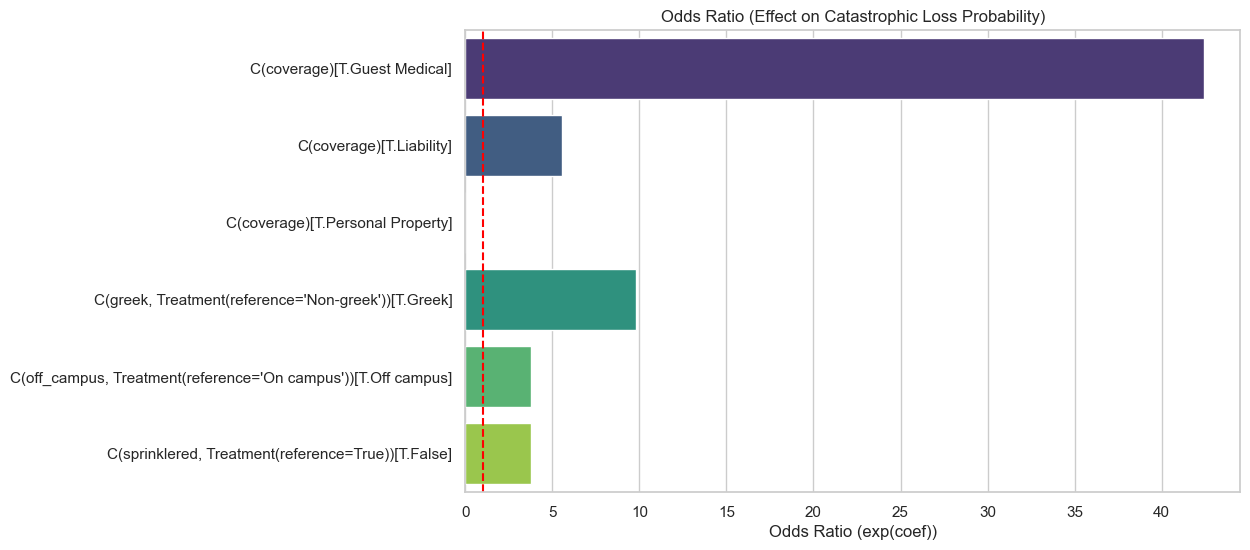

In [ ]:
plot_df = results[results["variable"]!="Intercept"].copy()

plt.figure(figsize=(10,6))
sns.barplot(
    data=plot_df,
    x="odds_ratio",
    y="variable",
    orient="h",
    palette="viridis"
)
plt.axvline(1, color="red", linestyle="--")  # OR=1 baseline
plt.title("Risk Factor Impact on Catastrophic Loss (Odds Ratios)")
plt.xlabel("Odds Ratio (exp(coef))")
plt.ylabel("")
plt.show()

In [27]:
df_loss["pred_prob"] = model.predict(df_loss)

df_loss[["amount","coverage","greek","pred_prob"]].head()


,amount,coverage,greek,pred_prob
40,990.596391,Personal Property,Non-greek,3.556090e-11
84,1172.942616,Personal Property,Greek,9.255195e-11
104,2106.469682,Personal Property,Greek,9.255195e-11
112,6943.265254,Liability,Non-greek,2.929614e-02
128,7197.105825,Guest Medical,Non-greek,5.780481e-02


In [50]:
df_loss["pred_large"] = (df_loss["pred_prob"] > 0.5).astype(int)


y_true = df_loss["large"]
y_pred = df_loss["pred_large"]
y_prob = df_loss["pred_prob"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))


Accuracy: 0.9554700384826827
Precision: 0.625
Recall: 0.27472527472527475
F1-score: 0.3816793893129771
ROC-AUC: 0.9582824582824583


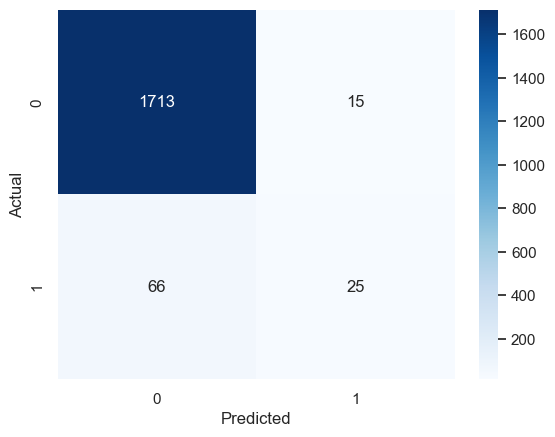

In [51]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [52]:
heatmap_df = (
    df_loss.groupby(["coverage", "greek", "off_campus", "sprinklered"])
           ["pred_prob"]
           .mean()
           .reset_index()
)

heatmap_df


,coverage,greek,off_campus,sprinklered,pred_prob
0,Additional Living Expense,Greek,Off campus,False,1.674341e-01
1,Additional Living Expense,Greek,Off campus,True,5.082818e-02
2,Additional Living Expense,Greek,On campus,False,5.062359e-02
3,Additional Living Expense,Greek,On campus,True,1.399993e-02
4,Additional Living Expense,Non-greek,Off campus,False,2.007677e-02
5,Additional Living Expense,Non-greek,Off campus,True,5.425921e-03
6,Additional Living Expense,Non-greek,On campus,False,5.403039e-03
7,Additional Living Expense,Non-greek,On campus,True,1.444434e-03
8,Guest Medical,Greek,Off campus,False,8.950625e-01
9,Guest Medical,Greek,Off campus,True,6.943027e-01


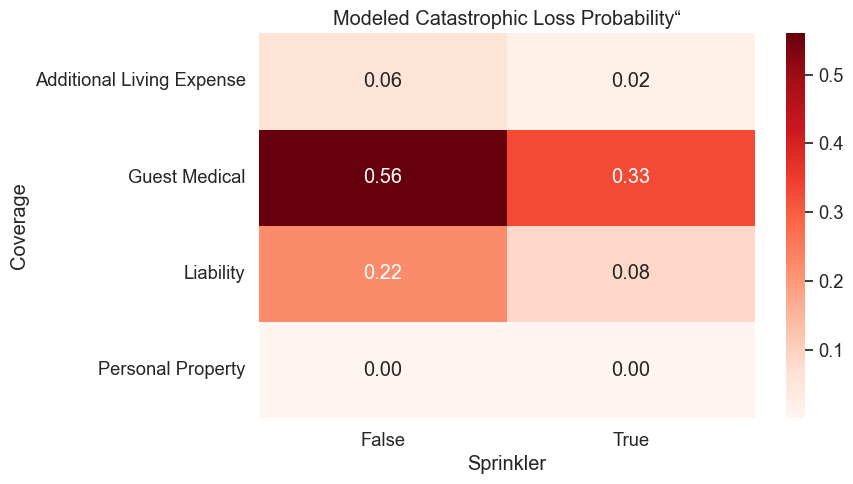

In [69]:
pivot = heatmap_df.pivot_table(
    values="pred_prob",
    index="coverage",
    columns="sprinklered"
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, cmap="Reds", fmt=".2f")
plt.title("Modeled Catastrophic Loss Probability“")
plt.xlabel("Sprinkler")
plt.ylabel("Coverage")
plt.show()


In [54]:
# ensure df_loss exists
df_loss = df[df["amount"] > 0].copy()

# 95th percentile threshold
threshold = df_loss["amount"].quantile(0.95)

# create large loss indicator
df_loss["large_loss"] = (df_loss["amount"] > threshold).astype(int)


c:\Users\ziang\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


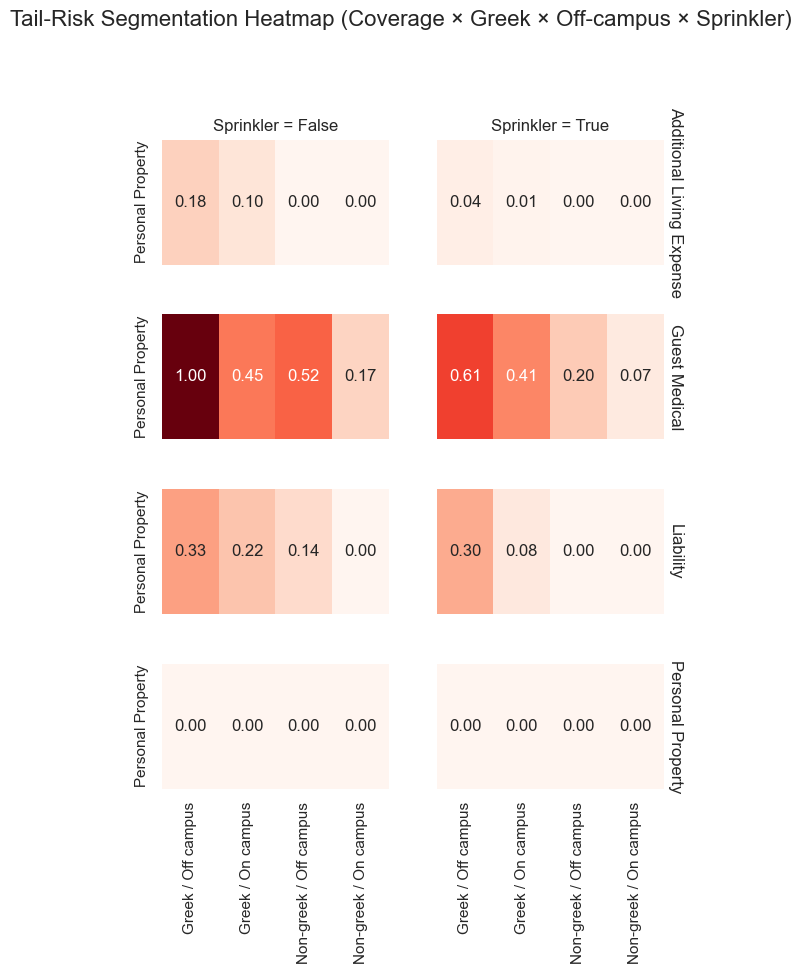

In [56]:
# Group by all four segmentation variables
seg = (
    df_loss.groupby(["coverage", "greek", "off_campus", "sprinklered"])
    .agg(
        count=("large_loss", "count"),
        large_rate=("large_loss", "mean")
    )
    .reset_index()
)

# Create merged column for column dimension
seg["group_col"] = seg["greek"] + " / " + seg["off_campus"]

# Create FacetGrid: 1 row per coverage, 2 facets (sprinklered yes/no)
g = sns.FacetGrid(
    seg,
    row="coverage",
    col="sprinklered",
    margin_titles=True,
    height=2.0,
    aspect=1.5
)

# Draw heatmap inside each facet
def heatmap_func(data, **kwargs):
    pivot = data.pivot_table(
        index="coverage",
        columns="group_col",
        values="large_rate",
        aggfunc="mean"
    )
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".2f",
        cmap="Reds",
        vmin=0,
        vmax=seg["large_rate"].max(),
        cbar=False,
        **kwargs
    )

g.map_dataframe(heatmap_func)
g.set_axis_labels("", "")
g.set_titles(row_template="{row_name}", col_template="Sprinkler = {col_name}")
plt.subplots_adjust(hspace=0.4)

plt.suptitle(
    "Tail-Risk Segmentation Heatmap (Coverage × Greek × Off-campus × Sprinkler)",
    y=1.05,
    fontsize=16
)

plt.show()

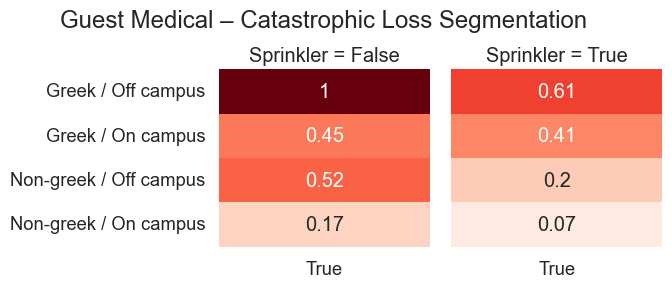

In [ ]:
gm = df_loss[df_loss["coverage"] == "Guest Medical"]

seg_gm = (
    gm.groupby(["greek", "off_campus", "sprinklered"])
      .agg(large_rate=("large_loss", "mean"))
      .reset_index()
)

seg_gm["group_col"] = seg_gm["greek"] + " / " + seg_gm["off_campus"]


g = sns.FacetGrid(
    seg_gm, 
    col="sprinklered", 
    height=3, 
    aspect=1.2, 
    margin_titles=True
)

def draw(data, **kwargs):
    pivot = data.pivot_table(
        index="group_col", 
        columns="sprinklered", 
        values="large_rate"
    )
    sns.heatmap(
        pivot,
        annot=True,
        cmap="Reds",
        vmin=0,
        vmax=seg_gm["large_rate"].max(),
        cbar=False
    )

g.map_dataframe(draw)
g.set_titles(col_template="Sprinkler = {col_name}")
g.set_axis_labels("", "")
plt.suptitle("Guest Medical – Catastrophic Loss Segmentation", y=1.05)
plt.show()


In [ ]:
tier_check = (
    df_loss.groupby("risk_tier")
    .agg(
        count=("amount","count"),
        avg_severity=("amount","mean"),
        large_rate=("large_loss","mean")
    )
)

# change large_rate to percentage
tier_check["large_rate"] = (tier_check["large_rate"] * 100).round(2)

# rename columns for clarity
tier_check = tier_check.rename(columns={"large_rate": "large_rate (%)"})

tier_check



,count,avg_severity,large_rate (%)
risk_tier,,,
1,869,3969.618907,4.03
2,407,4799.115515,4.91
3,543,5730.941401,6.63


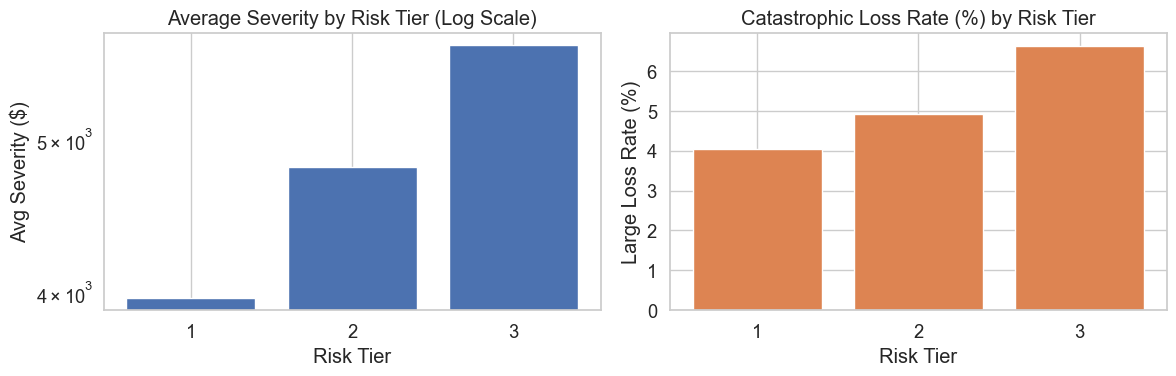

In [ ]:
tiers = tier_check.index.astype(str)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: average everity（log scale）
axes[0].bar(tiers, tier_check["avg_severity"], color=["#4C72B0"])
axes[0].set_yscale("log")
axes[0].set_title("Average Severity by Risk Tier (Log Scale)")
axes[0].set_xlabel("Risk Tier")
axes[0].set_ylabel("Avg Severity ($)")

# Right：Catastrophic loss rate (%)
axes[1].bar(tiers, tier_check["large_rate (%)"], color=["#DD8452"])
axes[1].set_title("Catastrophic Loss Rate (%) by Risk Tier")
axes[1].set_xlabel("Risk Tier")
axes[1].set_ylabel("Large Loss Rate (%)")

plt.tight_layout()
plt.show()